In [1]:
import pandas, numpy, seaborn, umap
import scipy, scipy.signal
import sklearn, sklearn.cluster
import MulticoreTSNE

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

# user-defined variables

In [3]:
expression_file = '/home/adrian/scratch/selected_expression.tsv'
output_dir = '/home/adrian/scratch/'

In [4]:
iso1 = 'ENST00000354449.7'
iso2 = 'ENST00000354956.9'

# read data

In [5]:
%%time
selected_expression = pandas.read_csv(expression_file, index_col=0, sep='\t')
print(selected_expression.shape)
selected_expression.head()

(46490, 4385)
CPU times: user 28.2 s, sys: 1.65 s, total: 29.8 s
Wall time: 30.5 s


GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
sample                                                                
ENST00000625998.2                 2.172597                 2.098120   
ENST00000583693.5                 1.679476                 1.659720   
ENST00000012134.6                 0.028054                 1.528813   
ENST00000403263.5                 2.737514                 2.433423   
ENST00000449352.6                 1.695411                 2.800497   

                   GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
sample                                                                 
ENST00000625998.2                  0.604361                 1.012243   
ENST00000583693.5                  2.343766                 2.182024   
ENST00000012134.6                  1.308149                 0.799196   
ENST00000403263.5                  2.221165                 2.084570   
ENST00000449352.6                  2.215746                 2.359610   

                   GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
sample                                                                 
ENST00000625998.2                 2.112940                  1.282651   
ENST00000583693.5                 1.608522                  2.342481   
ENST00000012134.6                 2.200149                  1.650502   
ENST00000403263.5                 2.304542                  2.238873   
ENST00000449352.6                 2.831991                  2.112632   

                   GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
sample                                                                
ENST00000625998.2                 2.350597                 1.055977   
ENST00000583693.5                 1.919266                 2.462014   
ENST00000012134.6                 1.646210                 2.311007   
ENST00000403263.5                 2.688859                 2.615937   
ENST00000449352.6                 2.839560                 2.607822   

                   GTEX-P44H-0526-SM-2XCF1  GTEX-11ONC-2326-SM-5HL6P  ...  \
sample                                                                ...   
ENST00000625998.2                 2.652690                  2.268121  ...   
ENST00000583693.5                 1.794654                  1.688779  ...   
ENST00000012134.6                 1.437005                  2.369605  ...   
ENST00000403263.5                 3.291015                  2.220693  ...   
ENST00000449352.6                 1.759019                  2.999159  ...   

                   GTEX-144GO-0126-SM-5LUAO  GTEX-1313W-1626-SM-5J1OE  \
sample                                                                  
ENST00000625998.2                  0.979851                  2.130198   
ENST00000583693.5                  2.027438                  1.520067   
ENST00000012134.6                  1.576889                  1.827558   
ENST00000403263.5                  2.220222                  2.060171   
ENST00000449352.6                  3.785498                  1.353480   

                   GTEX-12ZZY-1526-SM-5LZWF  GTEX-QMRM-0826-SM-3NB33  \
sample                                                                 
ENST00000625998.2                  1.992097                 1.513298   
ENST00000583693.5                  1.725912                 2.402364   
ENST00000012134.6                  2.260518                 1.542512   
ENST00000403263.5                  2.130275                 2.778681   
ENST00000449352.6                  2.671217                 2.489579   

                   GTEX-OOBK-2626-SM-2HMKY  GTEX-1117F-2826-SM-5GZXL  \
sample                                                                 
ENST00000625998.2                 1.761416                  2.140628   
ENST00000583693.5                 2.313324                  1.886362   
ENST00000012134.6                 2.087475                  1.687606   
ENST00000403263.5                 1.937410                  2.314922   
ENST00000449352.6       

# quantile normalization

In [6]:
%%time
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(selected_expression.values, axis=0), index=selected_expression.index, columns=selected_expression.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = selected_expression.rank(method="min").stack().astype(int).map(df_mean).unstack()

CPU times: user 50.2 s, sys: 5.72 s, total: 55.9 s
Wall time: 55.9 s


14.553924904476192
4385


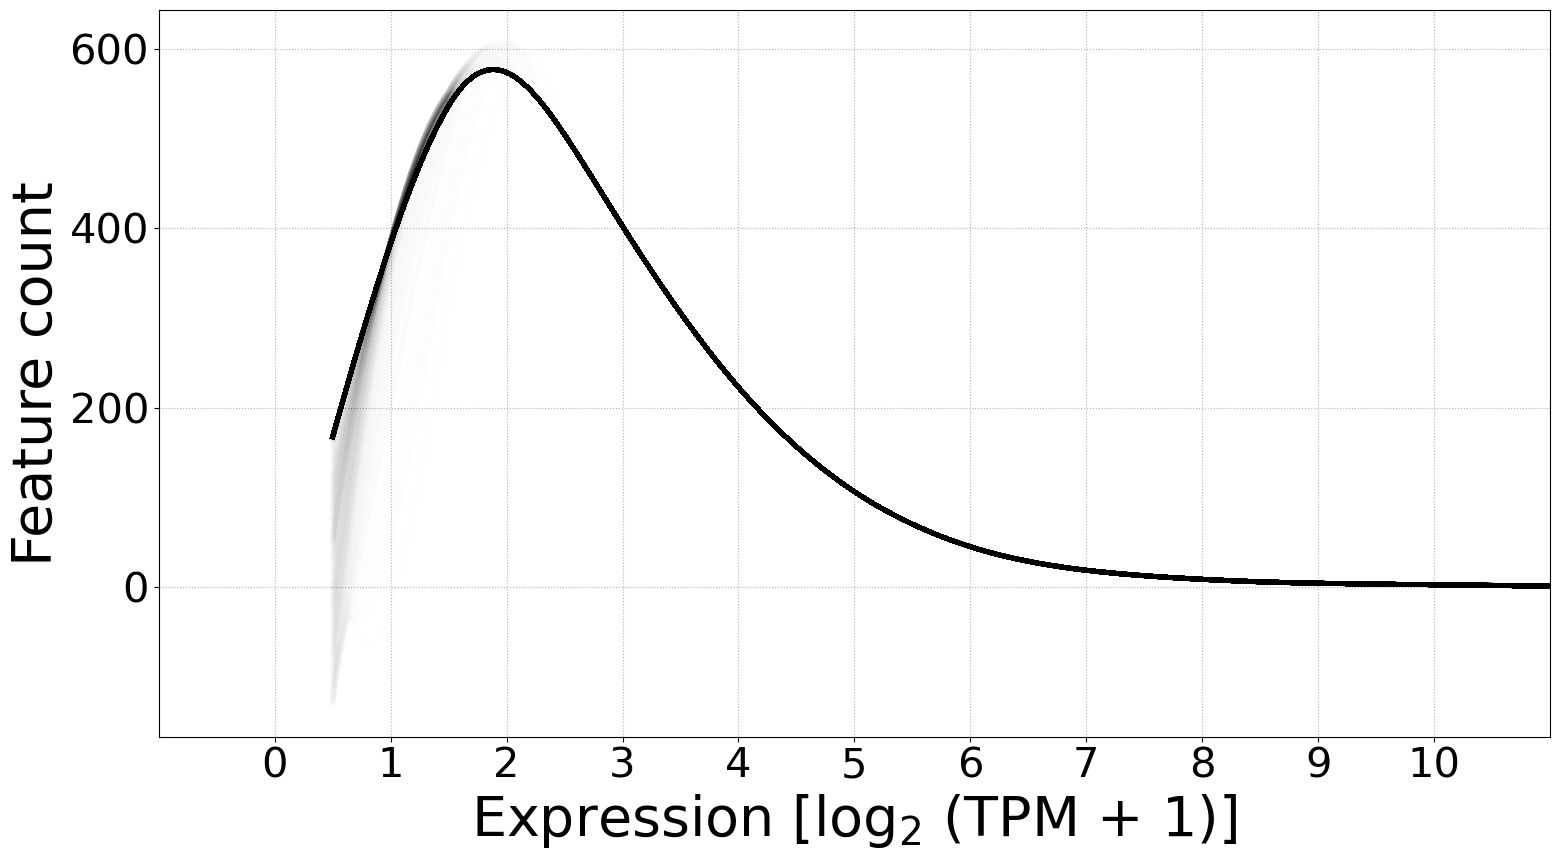

In [7]:
found_max = 19
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/2)

most_likely_expressions = []

selected_samples = []

for sample in qndf.columns:
        
    expression_values = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # determine most likely expression
    most_likely_expression = x[numpy.argmax(yhat)]
    most_likely_expressions.append(most_likely_expression)
    
    # sample selection
    if 1 <= most_likely_expression <= 2:
        selected_samples.append(sample)
    
    # plotting
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='black')
    
    # check
    if numpy.max(expression_values) > absolute_max:
        absolute_max = numpy.max(expression_values)

# check print
print(absolute_max)
print(len(selected_samples))

matplotlib.pyplot.xlim(-1, 11)                  
matplotlib.pyplot.xticks(range(0, 10+1))
matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [8]:
# define highly variable genes.plot cv as a fucntion of mean.
# http://pklab.med.harvard.edu/scw2014/subpop_tutorial.html

# z-score

In [9]:
zscore_df = scipy.stats.zscore(qndf, axis=1)
zscore_df.std(axis=1)

sample
ENST00000625998.2    1.000114
ENST00000583693.5    1.000114
ENST00000012134.6    1.000114
ENST00000403263.5    1.000114
ENST00000449352.6    1.000114
                       ...   
ENST00000470412.5    1.000114
ENST00000469534.1    1.000114
ENST00000507412.1    1.000114
ENST00000568351.1    1.000114
ENST00000491408.1    1.000114
Length: 46490, dtype: float64

In [10]:
print(zscore_df.max().max())
print(zscore_df.min().min())

15.804689630376652
-18.18179087330121


# exploratory visualization

## heatmap

In [11]:
zscore_df.rename_axis('Transcripts', inplace=True)
zscore_df.rename_axis('Samples', axis='columns', inplace=True)
print(zscore_df.shape)
zscore_df

(46490, 4385)


Samples            GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
Transcripts                                                           
ENST00000625998.2                 0.201517                 0.036483   
ENST00000583693.5                -0.157536                -0.387785   
ENST00000012134.6                -1.858374                -0.230357   
ENST00000403263.5                 1.824639                 0.803760   
ENST00000449352.6                -0.714858                 0.391161   
...                                    ...                      ...   
ENST00000470412.5                -0.343926                -0.700203   
ENST00000469534.1                -0.658335                -0.508709   
ENST00000507412.1                 1.256783                 1.699418   
ENST00000568351.1                -1.172953                 0.246373   
ENST00000491408.1                -0.713929                 0.883018   

Samples            GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
Transcripts                                                            
ENST00000625998.2                 -2.678424                -1.913425   
ENST00000583693.5                  0.348795                 0.398806   
ENST00000012134.6                 -1.101552                -1.678630   
ENST00000403263.5                 -0.939061                -0.804629   
ENST00000449352.6                 -0.649496                -0.251540   
...                                     ...                      ...   
ENST00000470412.5                  1.493895                -0.896921   
ENST00000469534.1                 -1.181746                -1.279740   
ENST00000507412.1                 -0.896584                -0.779208   
ENST00000568351.1                  0.766133                 0.853352   
ENST00000491408.1                 -0.625723                -0.343984   

Samples            GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
Transcripts                                                            
ENST00000625998.2                -0.196345                 -1.555508   
ENST00000583693.5                -1.129253                  0.687884   
ENST00000012134.6                 0.351186                 -0.498028   
ENST00000403263.5                -0.097733                 -0.456441   
ENST00000449352.6                 0.275481                 -0.622791   
...                                    ...                       ...   
ENST00000470412.5                -0.323228                  1.640890   
ENST00000469534.1                -0.498626                 -0.508271   
ENST00000507412.1                 1.566538                 -0.102175   
ENST00000568351.1                -0.234204                  0.774586   
ENST00000491408.1                -0.327609                 -0.707473   

Samples            GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
Transcripts                                                           
ENST00000625998.2                 0.632833                -2.103236   
ENST00000583693.5                 0.582988                 0.557330   
ENST00000012134.6                 0.051742                 0.196520   
ENST00000403263.5                 2.261055                 0.277584   
ENST00000449352.6                 0.703996                -0.210234   
...                                    ...                      ...   
ENST00000470412.5                 0.597571                -0.869830   
ENST00000469534.1                 0.492896                -0.938374   
ENST00000507412.1                -1.142376                -0.776279   
ENST00000568351.1                 0.211088                 1.161617   
ENST00000491408.1                 0.368435                 0.039041   

Samples            GTEX-P44H-0526-SM-2XCF1  GTEX-11ONC-2326-SM-5HL6P  ...  \
Transcripts                                                           ...   
ENST00000625998.2                 0.078840                 -0.065244  ...   
ENST00000583693.5                -1.350953     

In [12]:
# reduction of 10 runs for 68 CPU s
# reduction of 3 runs for 7 CPU min

print(zscore_df.shape)

reduction = 10
test = zscore_df.iloc[:int(zscore_df.shape[0]/reduction), :] 

print(test.shape)
test.tail()

(46490, 4385)
(4649, 4385)


Samples            GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
Transcripts                                                           
ENST00000348849.7                -1.707196                 0.688899   
ENST00000589795.1                -0.377745                 0.468480   
ENST00000562949.1                 0.317549                 0.542115   
ENST00000251412.7                -1.276873                -0.346841   
ENST00000542575.6                 0.599197                 0.770189   

Samples            GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
Transcripts                                                            
ENST00000348849.7                 -0.736117                 0.309910   
ENST00000589795.1                 -0.022963                -0.771088   
ENST00000562949.1                  0.346984                 0.026656   
ENST00000251412.7                  0.263091                -0.424101   
ENST00000542575.6                 -1.385960                -0.332373   

Samples            GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
Transcripts                                                            
ENST00000348849.7                -0.153891                  0.975849   
ENST00000589795.1                 1.093563                 -0.730224   
ENST00000562949.1                 0.685419                  0.087700   
ENST00000251412.7                 0.282845                 -0.569429   
ENST00000542575.6                -0.115107                  1.233306   

Samples            GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
Transcripts                                                           
ENST00000348849.7                -0.546437                -0.515082   
ENST00000589795.1                -0.543485                -1.089323   
ENST00000562949.1                 0.845460                 0.726462   
ENST00000251412.7                -2.270035                -0.425158   
ENST00000542575.6                -0.108390                -1.130502   

Samples            GTEX-P44H-0526-SM-2XCF1  GTEX-11ONC-2326-SM-5HL6P  ...  \
Transcripts                                                           ...   
ENST00000348849.7                -2.060149                 -0.077853  ...   
ENST00000589795.1                 1.276496                  1.792976  ...   
ENST00000562949.1                -0.306852                  0.247636  ...   
ENST00000251412.7                 0.442133                  0.765774  ...   
ENST00000542575.6                -0.305168                  0.143098  ...   

Samples            GTEX-144GO-0126-SM-5LUAO  GTEX-1313W-1626-SM-5J1OE  \
Transcripts                                                             
ENST00000348849.7                 -0.477628                  0.913110   
ENST00000589795.1                 -0.648347                  0.093792   
ENST00000562949.1                  0.007988                 -0.690352   
ENST00000251412.7                  0.006474                  0.543840   
ENST00000542575.6                 -0.977140                  0.290886   

Samples            GTEX-12ZZY-1526-SM-5LZWF  GTEX-QMRM-0826-SM-3NB33  \
Transcripts                                                            
ENST00000348849.7                 -0.986878                 0.349048   
ENST00000589795.1                  0.742699                -1.138919   
ENST00000562949.1                  0.092866                -1.312112   
ENST00000251412.7                  0.873748                -0.273644   
ENST00000542575.6                 -1.290737                 1.237044   

Samples            GTEX-OOBK-2626-SM-2HMKY  GTEX-1117F-2826-SM-5GZXL  \
Transcripts                                                            
ENST00000348849.7                -0.215304                  0.973665   
ENST00000589795.1                -1.423723                 -0.775522   
ENST00000562949.1                 1.359463                 -1.923233   
ENST00000251412.7                -0.926193                 -0.720034   
ENST0

In [13]:
nomiss = zscore_df.loc[[iso1, iso2], :]
print(test.shape)
print(nomiss.shape)
test = pandas.concat([test, nomiss])
print(test.shape)
test.tail()

(4649, 4385)
(2, 4385)
(4651, 4385)


Samples            GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
Transcripts                                                           
ENST00000562949.1                 0.317549                 0.542115   
ENST00000251412.7                -1.276873                -0.346841   
ENST00000542575.6                 0.599197                 0.770189   
ENST00000354449.7                -3.184409                 0.364421   
ENST00000354956.9                 1.265877                 0.719010   

Samples            GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
Transcripts                                                            
ENST00000562949.1                  0.346984                 0.026656   
ENST00000251412.7                  0.263091                -0.424101   
ENST00000542575.6                 -1.385960                -0.332373   
ENST00000354449.7                 -1.403553                 0.298591   
ENST00000354956.9                 -1.056392                -0.682643   

Samples            GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
Transcripts                                                            
ENST00000562949.1                 0.685419                  0.087700   
ENST00000251412.7                 0.282845                 -0.569429   
ENST00000542575.6                -0.115107                  1.233306   
ENST00000354449.7                 0.633081                 -0.140977   
ENST00000354956.9                -1.142360                  1.029533   

Samples            GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
Transcripts                                                           
ENST00000562949.1                 0.845460                 0.726462   
ENST00000251412.7                -2.270035                -0.425158   
ENST00000542575.6                -0.108390                -1.130502   
ENST00000354449.7                 0.606997                 0.226263   
ENST00000354956.9                 1.076049                -0.996015   

Samples            GTEX-P44H-0526-SM-2XCF1  GTEX-11ONC-2326-SM-5HL6P  ...  \
Transcripts                                                           ...   
ENST00000562949.1                -0.306852                  0.247636  ...   
ENST00000251412.7                 0.442133                  0.765774  ...   
ENST00000542575.6                -0.305168                  0.143098  ...   
ENST00000354449.7                 0.295672                  1.194365  ...   
ENST00000354956.9                 0.476427                 -0.828226  ...   

Samples            GTEX-144GO-0126-SM-5LUAO  GTEX-1313W-1626-SM-5J1OE  \
Transcripts                                                             
ENST00000562949.1                  0.007988                 -0.690352   
ENST00000251412.7                  0.006474                  0.543840   
ENST00000542575.6                 -0.977140                  0.290886   
ENST00000354449.7                  0.079223                 -0.910887   
ENST00000354956.9                 -0.874937                 -0.799387   

Samples            GTEX-12ZZY-1526-SM-5LZWF  GTEX-QMRM-0826-SM-3NB33  \
Transcripts                                                            
ENST00000562949.1                  0.092866                -1.312112   
ENST00000251412.7                  0.873748                -0.273644   
ENST00000542575.6                 -1.290737                 1.237044   
ENST00000354449.7                  0.536850                 0.492280   
ENST00000354956.9                 -1.142360                 0.477387   

Samples            GTEX-OOBK-2626-SM-2HMKY  GTEX-1117F-2826-SM-5GZXL  \
Transcripts                                                            
ENST00000562949.1                 1.359463                 -1.923233   
ENST00000251412.7                -0.926193                 -0.720034   
ENST00000542575.6                 0.302907                  0.868911   
ENST00000354449.7                -0.115982                 -0.815245   
ENST0

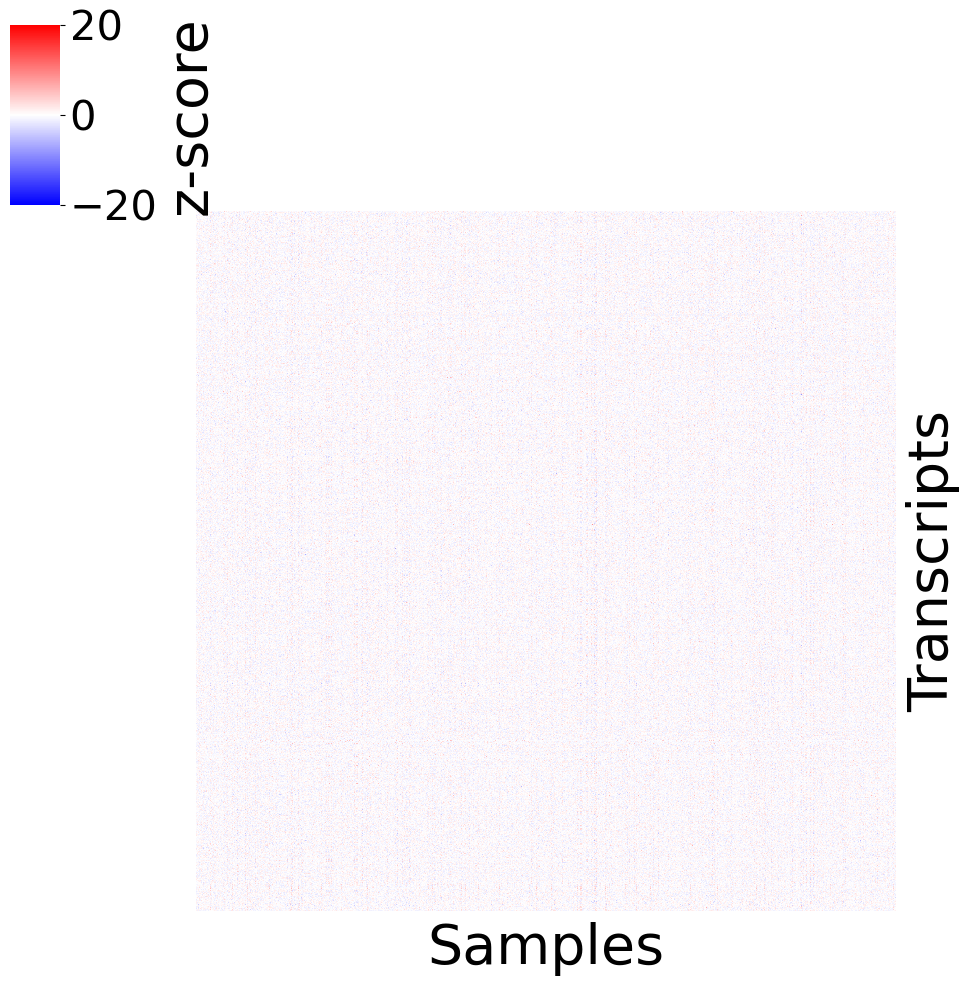

CPU times: user 9.64 s, sys: 284 ms, total: 9.93 s
Wall time: 9.92 s


In [14]:
%%time
seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=False, 
                   col_cluster=False, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                  )
matplotlib.pyplot.show()

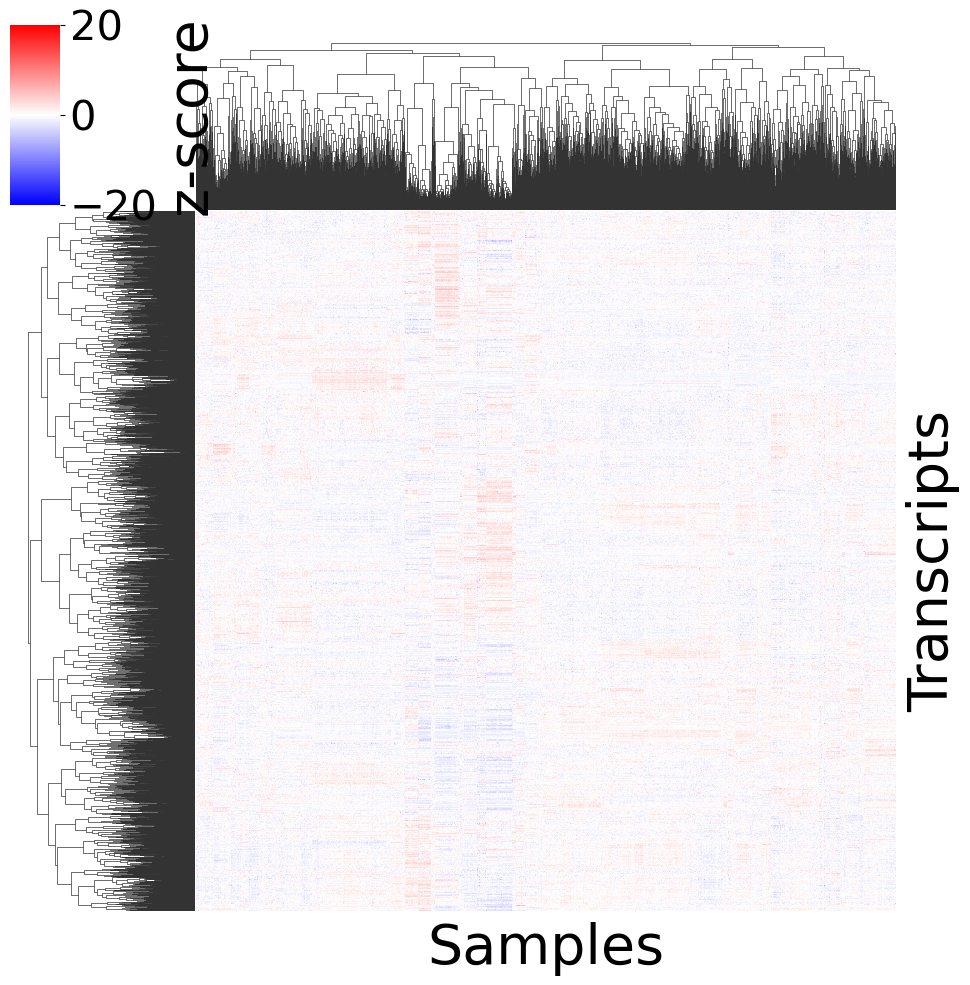

CPU times: user 1min, sys: 279 ms, total: 1min
Wall time: 1min


In [15]:
%%time
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric
                  )
matplotlib.pyplot.show()

## dimensionality reduction

### UMAP

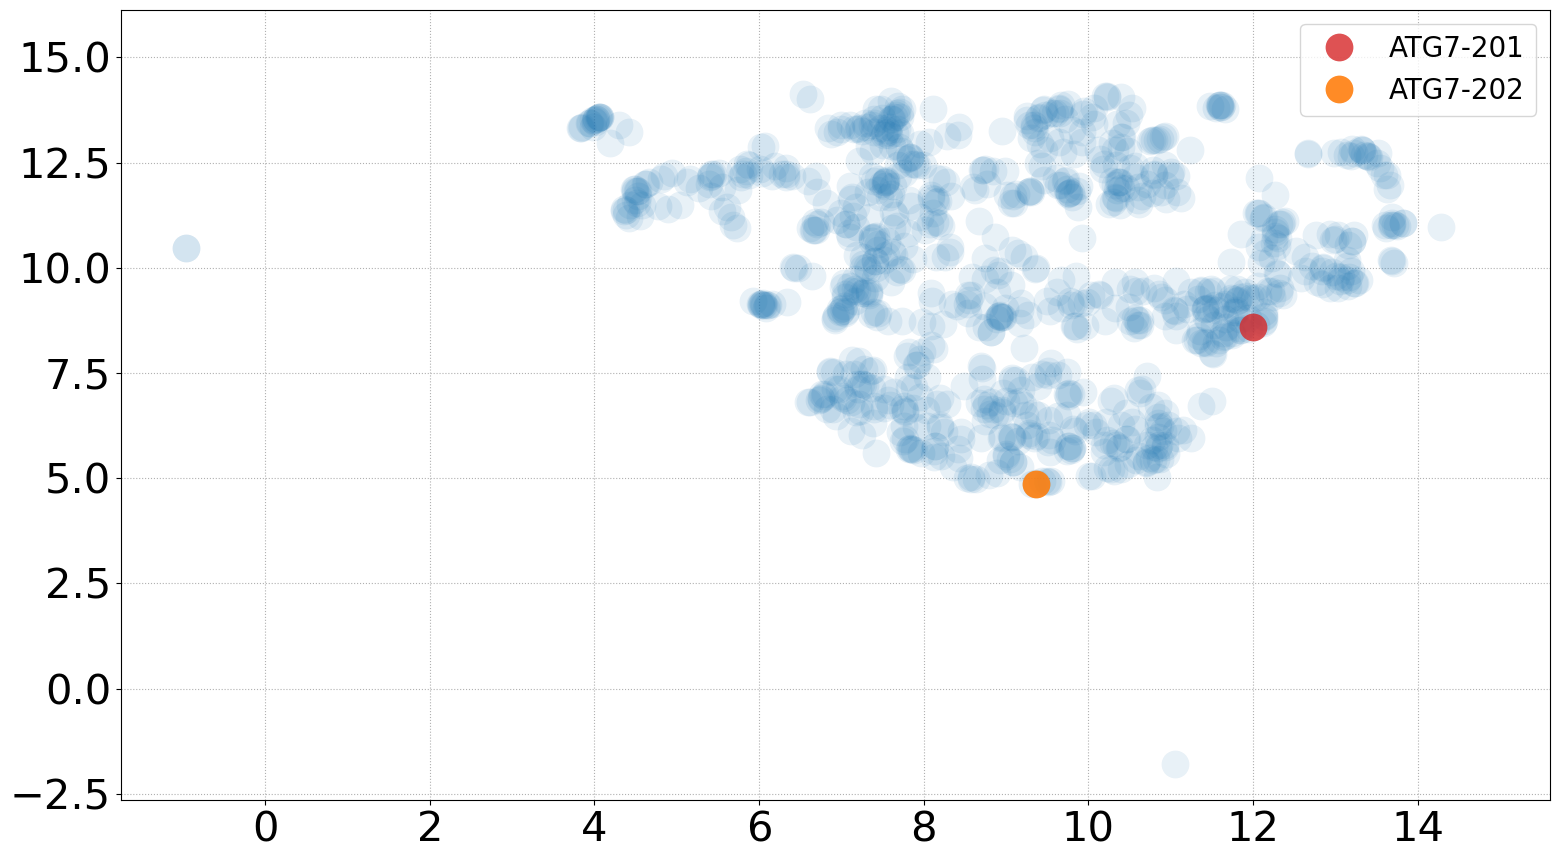

(4651, 2)
CPU times: user 37.2 s, sys: 124 ms, total: 37.4 s
Wall time: 12.6 s


X          Y
Transcripts                            
ENST00000625998.2   9.529302  13.073818
ENST00000583693.5   8.048554  12.199024
ENST00000012134.6   8.612539   8.784103
ENST00000403263.5  10.514315  12.194240
ENST00000449352.6   7.494384   6.701528
...                      ...        ...
ENST00000562949.1   7.794905   6.482483
ENST00000251412.7   8.842150   9.617598
ENST00000542575.6  12.226903  10.765784
ENST00000354449.7  11.997727   8.596222
ENST00000354956.9   9.370191   4.856771

[4651 rows x 2 columns]

In [16]:
%%time
runUmap = umap.UMAP(metric='correlation',
                    n_neighbors=5,
                    min_dist=0,
                    learning_rate=0.5
                   ).fit_transform
dr_umap = runUmap(test)
positionsu = pandas.DataFrame(dr_umap, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionsu['X'], positionsu['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20, markevery=5)

matplotlib.pyplot.plot(positionsu.loc[iso1, 'X'], positionsu.loc[iso1, 'Y'], 'o', alpha=0.8, markeredgecolor='None', ms=20, color='tab:red', label='ATG7-201')
matplotlib.pyplot.plot(positionsu.loc[iso2, 'X'], positionsu.loc[iso2, 'Y'], 'o', alpha=0.9, markeredgecolor='None', ms=20, color='tab:orange', label='ATG7-202')

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

print(positionsu.shape)
positionsu

### tSNE

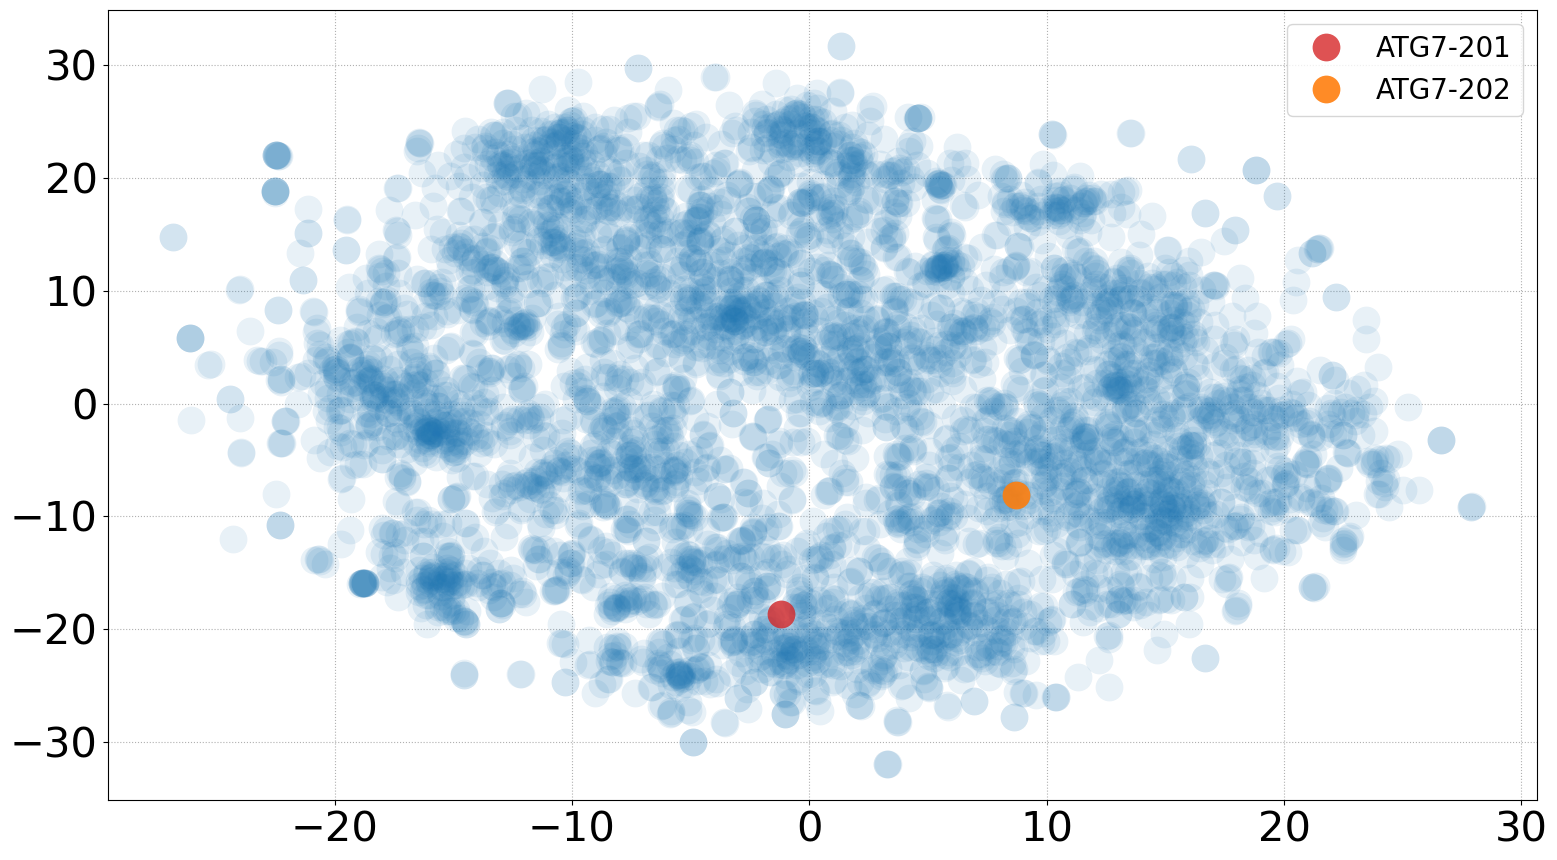

CPU times: user 8min 1s, sys: 2min 28s, total: 10min 29s
Wall time: 32.9 s


In [17]:
%%time
tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=20)
dr_tsne = tsne.fit_transform(test)
positionst = pandas.DataFrame(dr_tsne, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionst['X'], positionst['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.plot(positionst.loc[iso1, 'X'], positionst.loc[iso1, 'Y'], 'o', alpha=0.8, markeredgecolor='None', ms=20, color='tab:red', label='ATG7-201')
matplotlib.pyplot.plot(positionst.loc[iso2, 'X'], positionst.loc[iso2, 'Y'], 'o', alpha=0.9, markeredgecolor='None', ms=20, color='tab:orange', label='ATG7-202')

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# cluster data

In [23]:
%%time 
all_ks = range(2, 10)
successes = []; all_ss = [];  all_khi = []; all_dbi = []
groupings = []
for k in all_ks:
    
    print(k, end=' '),
    
    kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(test)
    
    # deterimine success
    results = pandas.DataFrame(kmeans.labels_, columns=['label'], index=test.index)
    if results.loc[iso1, 'label'] == results.loc[iso2, 'label']:
        success = 0
    else:
        success = 1
    successes.append(success)
    
    # calculate and store goodness indices
    ss = sklearn.metrics.silhouette_score(test, kmeans.labels_, metric='correlation')
    khi = sklearn.metrics.calinski_harabasz_score(test, kmeans.labels_)
    dbi = sklearn.metrics.davies_bouldin_score(test, kmeans.labels_)
    all_ss.append(ss); all_khi.append(khi); all_dbi.append(dbi)

    # store partitions
    groupings.append(kmeans.labels_)
print()

2 3 4 5 6 7 8 9 CPU times: user 12min 1s, sys: 3.29 s, total: 12min 5s
Wall time: 3min 52s


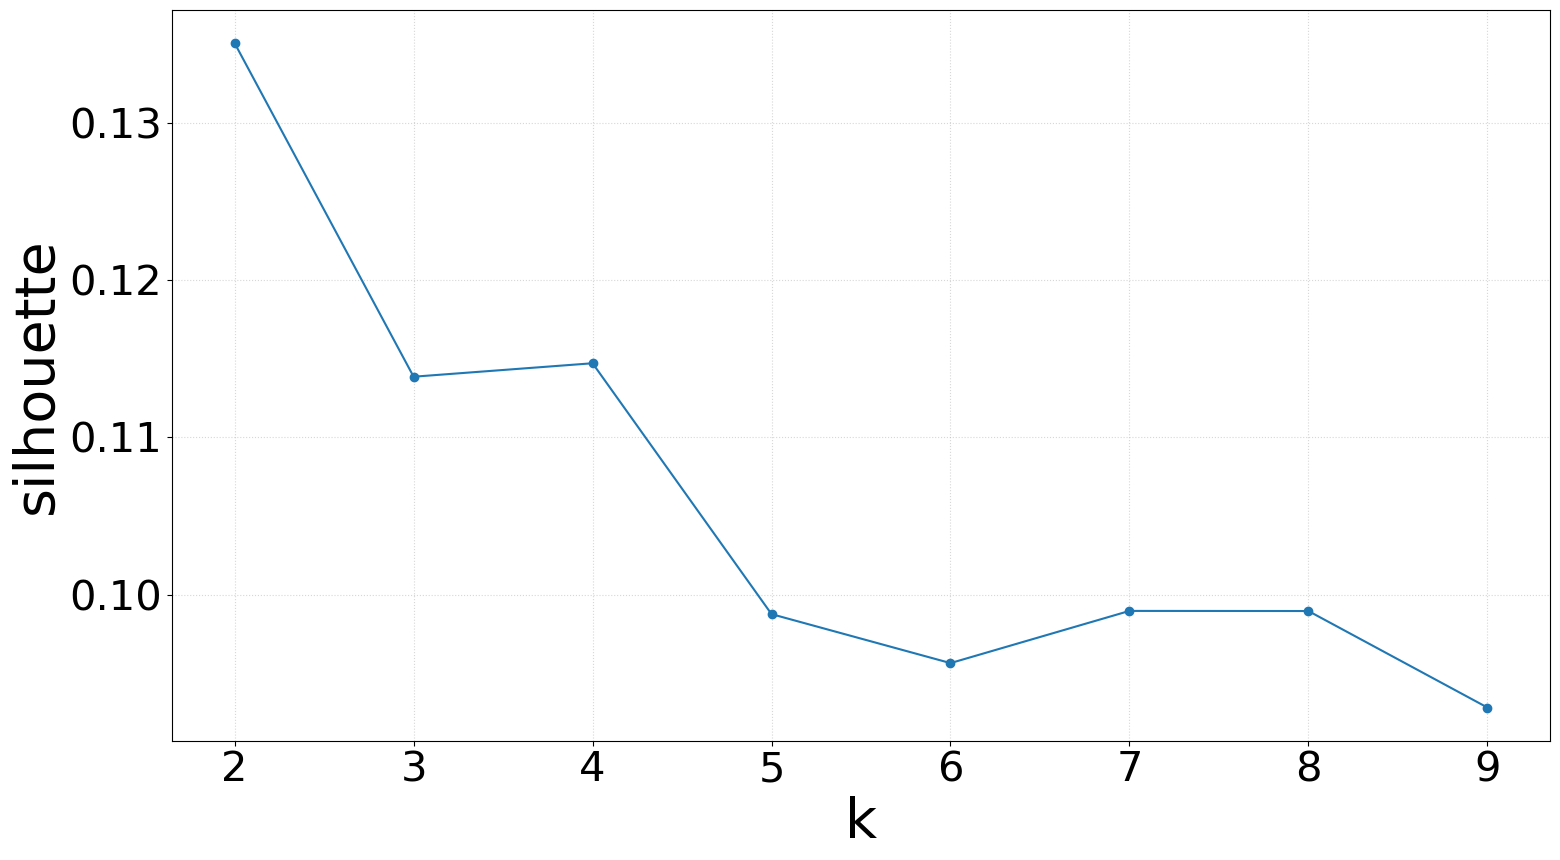

In [24]:
# silhouette: between -1 and 1, 0 being indiferent, 1 very good.
matplotlib.pyplot.plot(all_ks, all_ss, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('silhouette')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

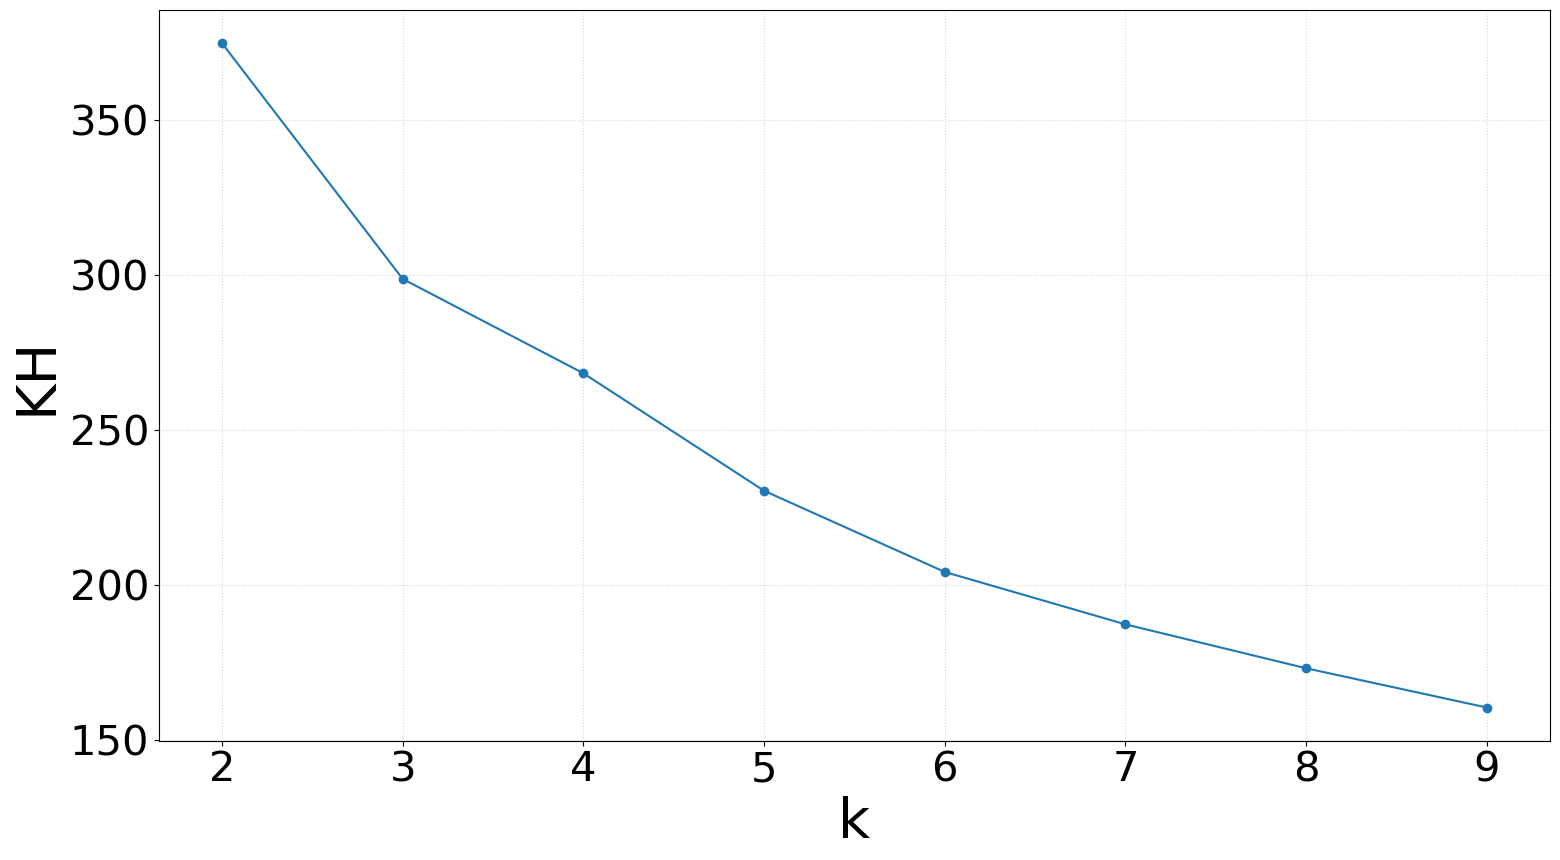

In [25]:
matplotlib.pyplot.plot(all_ks, all_khi, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('KH')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

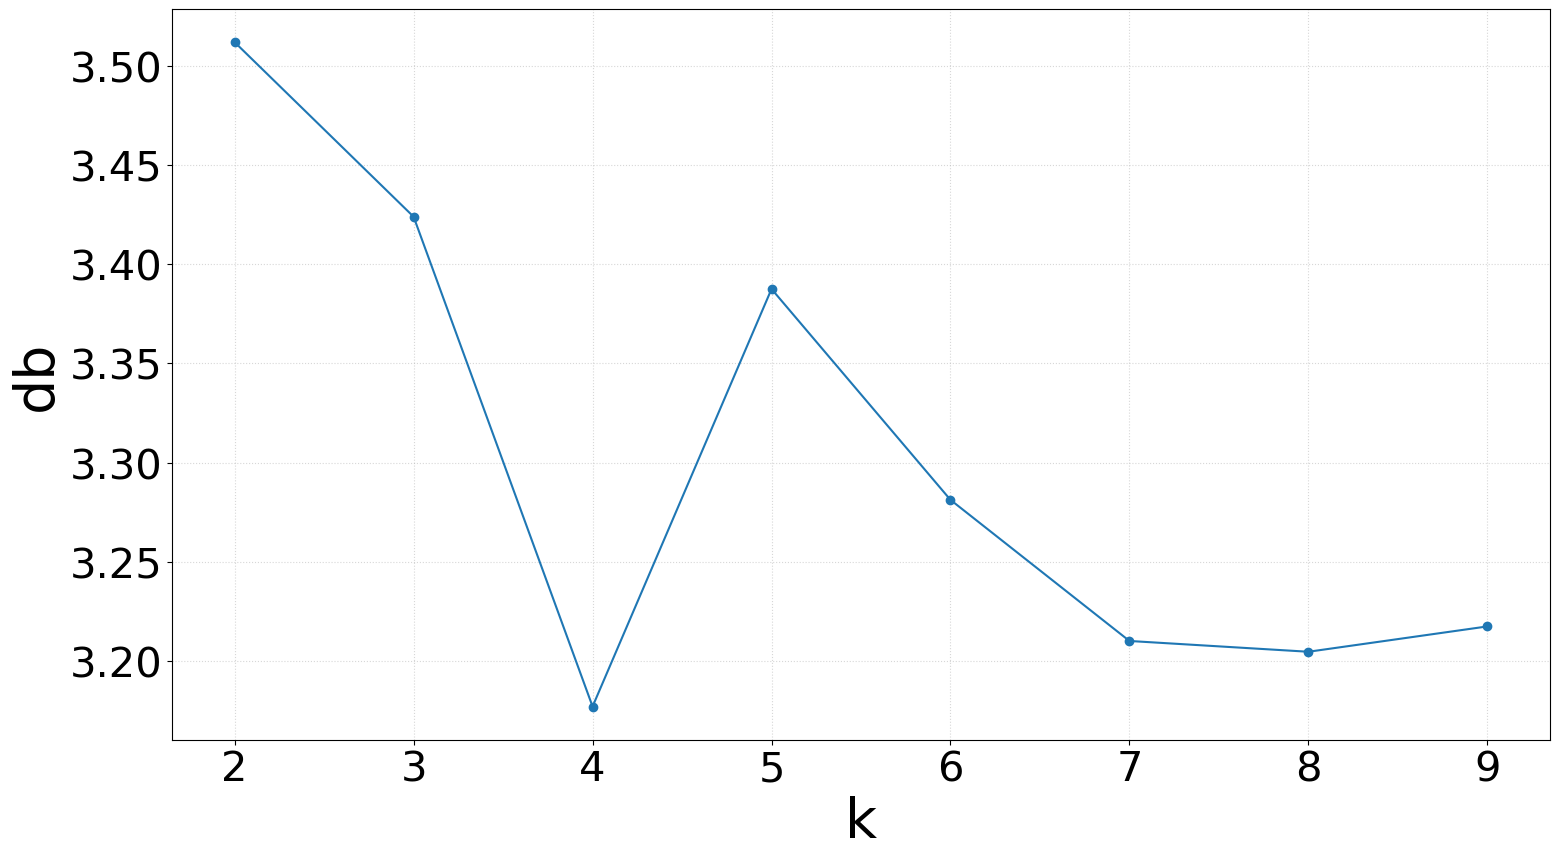

In [26]:
# The minimum score is zero, with lower values indicating better clustering.
matplotlib.pyplot.plot(all_ks, all_dbi, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('db')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

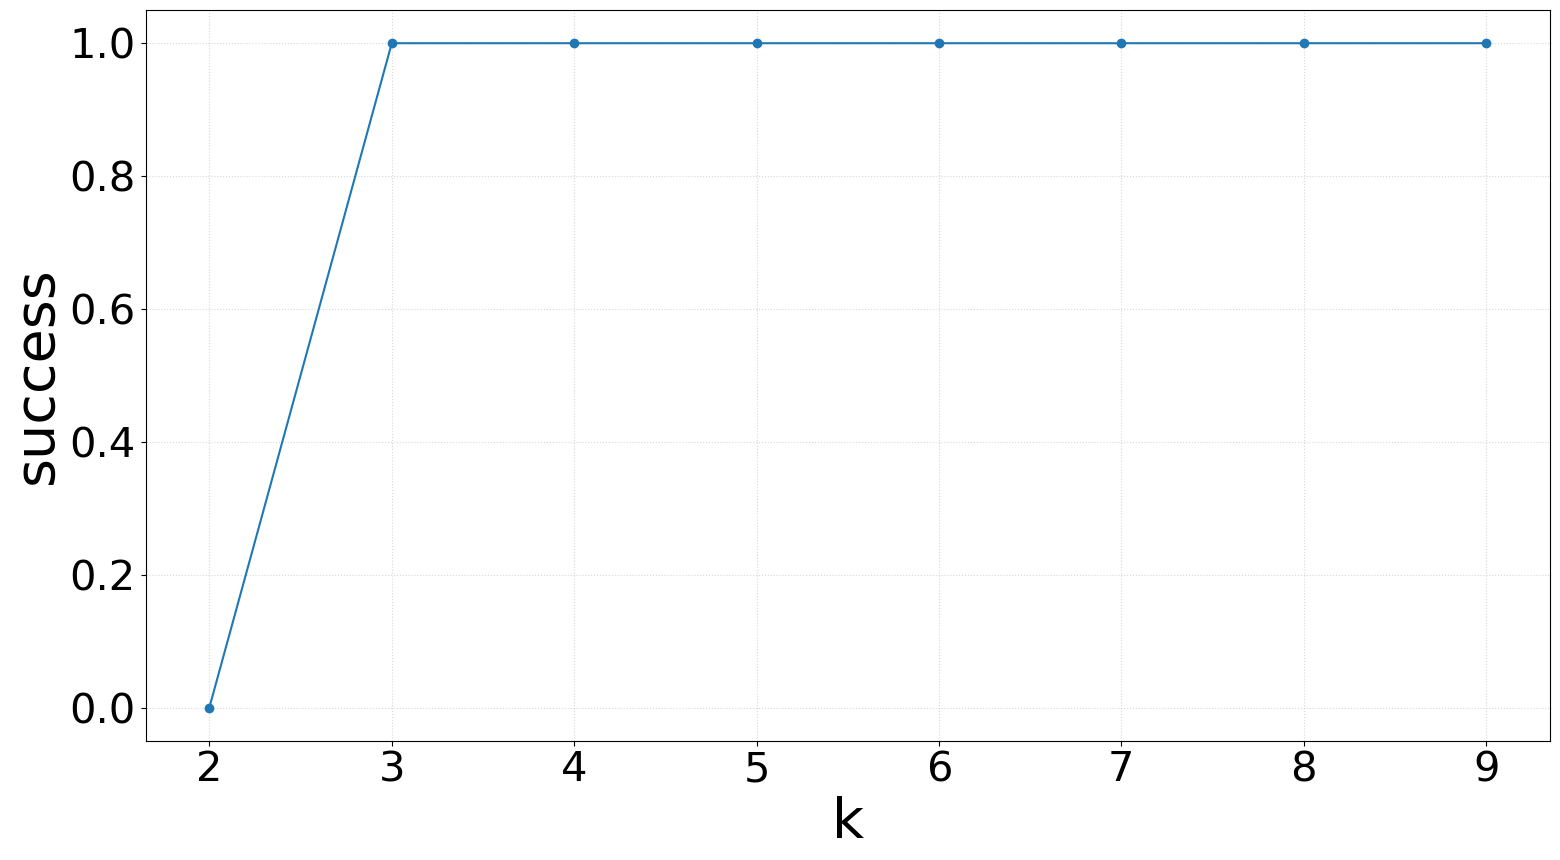

In [27]:
matplotlib.pyplot.plot(all_ks, successes, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('success')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## heatmap with labels

In [29]:
print(test.index.get_loc(iso1))
print(test.index.get_loc(iso2))

4649
4650


In [38]:
observed_best_k = 4
best_index = all_ks.index(observed_best_k)
labels = groupings[best_index]

print(set(labels))

print('ATG7-201 is in cluster {}'.format(labels[test.index.get_loc(iso1)]))
print('ATG7-202 is in cluster {}'.format(labels[test.index.get_loc(iso2)]))

{0, 1, 2, 3}
ATG7-201 is in cluster 1
ATG7-202 is in cluster 3


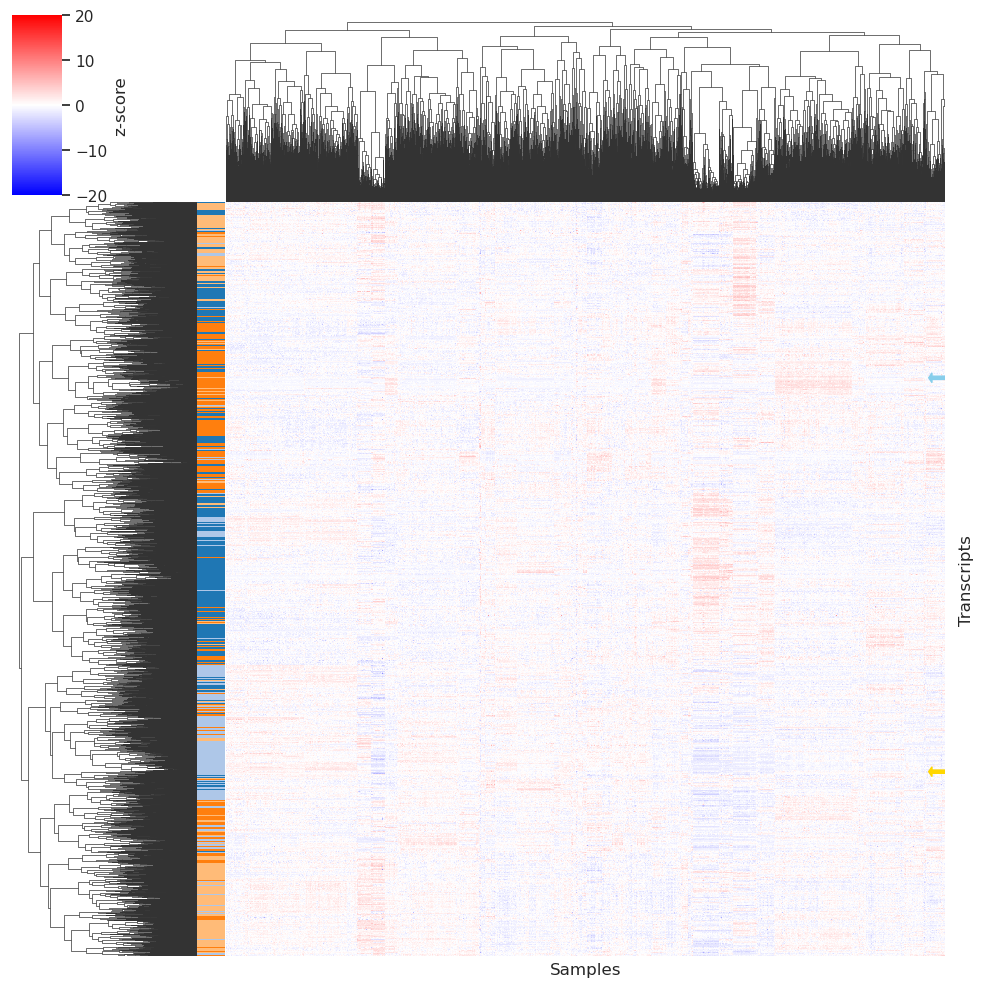

CPU times: user 58.3 s, sys: 324 ms, total: 58.6 s
Wall time: 58.6 s


In [196]:
%%time

cmap = matplotlib.pyplot.cm.get_cmap('tab20')
k_colors = cmap(labels)

linkage_method = 'complete'
distance_metric = 'correlation'

clustergrid = seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric,
                   row_colors=k_colors
                  )

# adding where isoforms fall
loc1 = clustergrid.dendrogram_row.reordered_ind.index(test.index.get_loc(iso1))
loc2 = clustergrid.dendrogram_row.reordered_ind.index(test.index.get_loc(iso2))
ax = clustergrid.ax_heatmap
ax.add_patch(matplotlib.patches.Arrow(test.shape[1], loc1, dx=-100, dy=0, color='gold', width=100))
ax.add_patch(matplotlib.patches.Arrow(test.shape[1], loc2, dx=-100, dy=0, color='skyblue', width=100))
matplotlib.pyplot.show()

In [186]:
iso1clusterlabel = labels[test.index.get_loc(iso1)]
iso2clusterlabel = labels[test.index.get_loc(iso2)]
print(iso1clusterlabel, iso2clusterlabel)

1 3


ENST00000354449.7
ENST00000354956.9


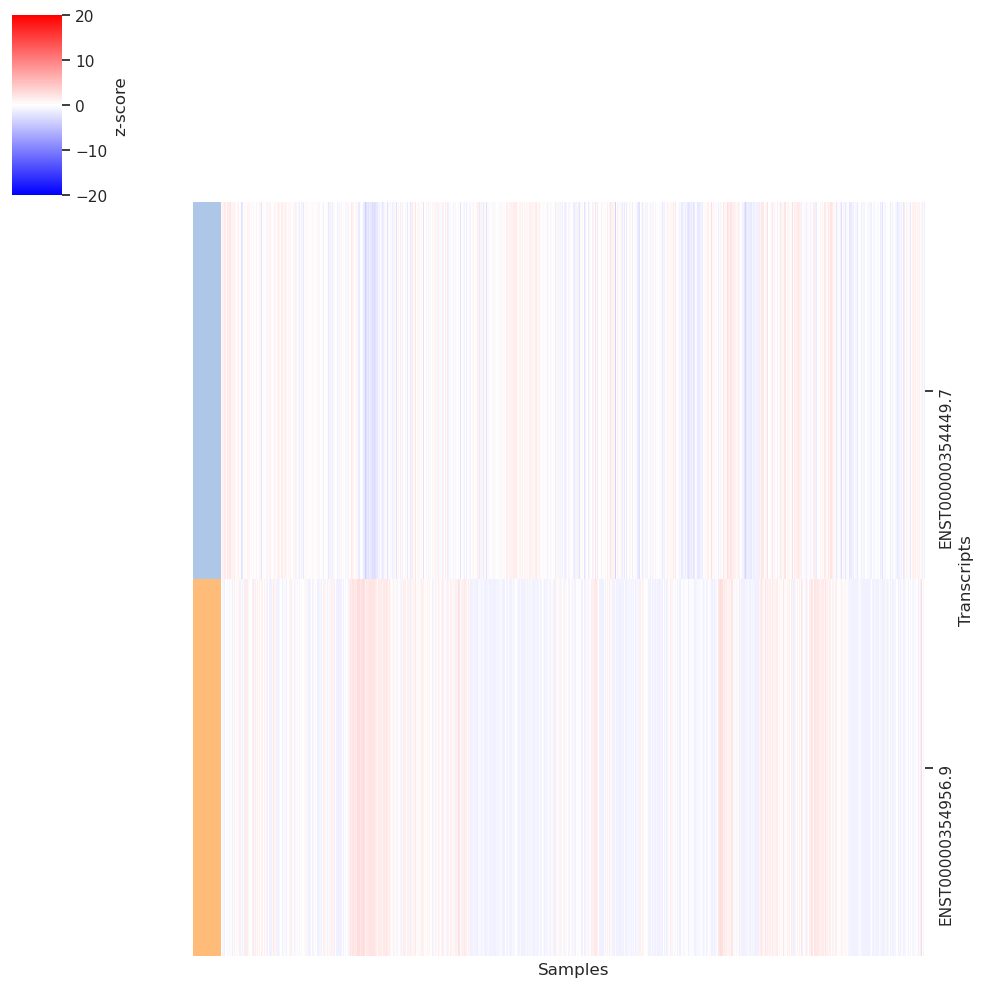

In [187]:
# only the two isoforms
print(iso1)
print(iso2)
seaborn.set(font_scale=1) 
seaborn.clustermap(
    test.iloc[[test.index.get_loc(iso1), test.index.get_loc(iso2)], clustergrid.dendrogram_col.reordered_ind], 
    cmap='bwr', 
    vmin=-20, vmax=20,
    row_cluster=False, col_cluster=False, 
    cbar_kws={'label':'z-score'},
    xticklabels=False, yticklabels=True,  
    row_colors=cmap([iso1clusterlabel, iso2clusterlabel])
)
matplotlib.pyplot.show()

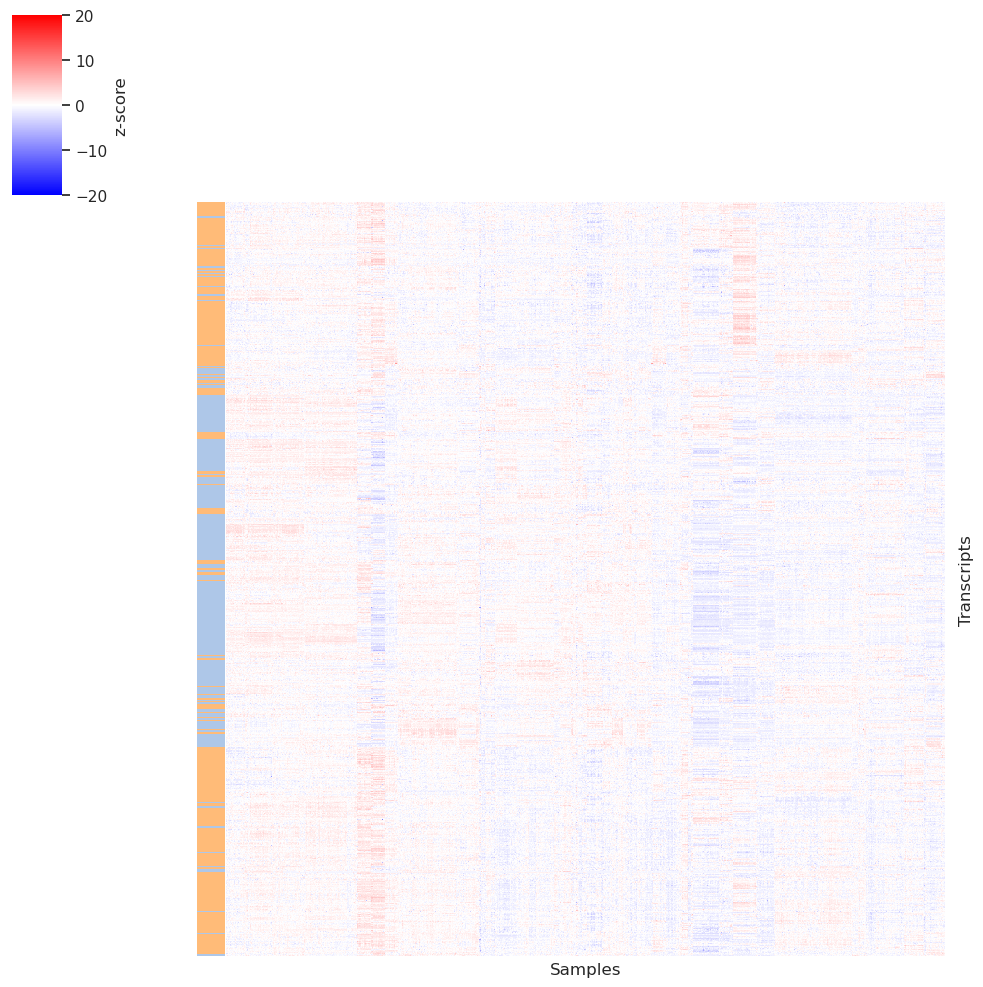

942 1061
True False
True False


In [199]:
# only the two clusters
cluster_indexes = []
cluster_labels = []
iso1_cluster_names = []; iso2_cluster_names = []
for row in clustergrid.dendrogram_row.reordered_ind:
    if labels[row] == iso1clusterlabel:
        cluster_indexes.append(row); cluster_labels.append(iso1clusterlabel)
        iso1_cluster_names.append(test.index[row])
    if labels[row] == iso2clusterlabel:
        cluster_indexes.append(row); cluster_labels.append(iso2clusterlabel)
        iso2_cluster_names.append(test.index[row])

seaborn.clustermap(
    test.iloc[cluster_indexes, clustergrid.dendrogram_col.reordered_ind], 
    cmap='bwr', 
    vmin=-20, vmax=20,
    row_cluster=False, col_cluster=False, 
    cbar_kws={'label':'z-score'},
    xticklabels=False, yticklabels=False,  
    row_colors=cmap(cluster_labels)
)
matplotlib.pyplot.show()

print(len(iso1_cluster_names), len(iso2_cluster_names))
print(iso1 in iso1_cluster_names, iso1 in iso2_cluster_names)
print(iso2 in iso2_cluster_names, iso2 in iso1_cluster_names)

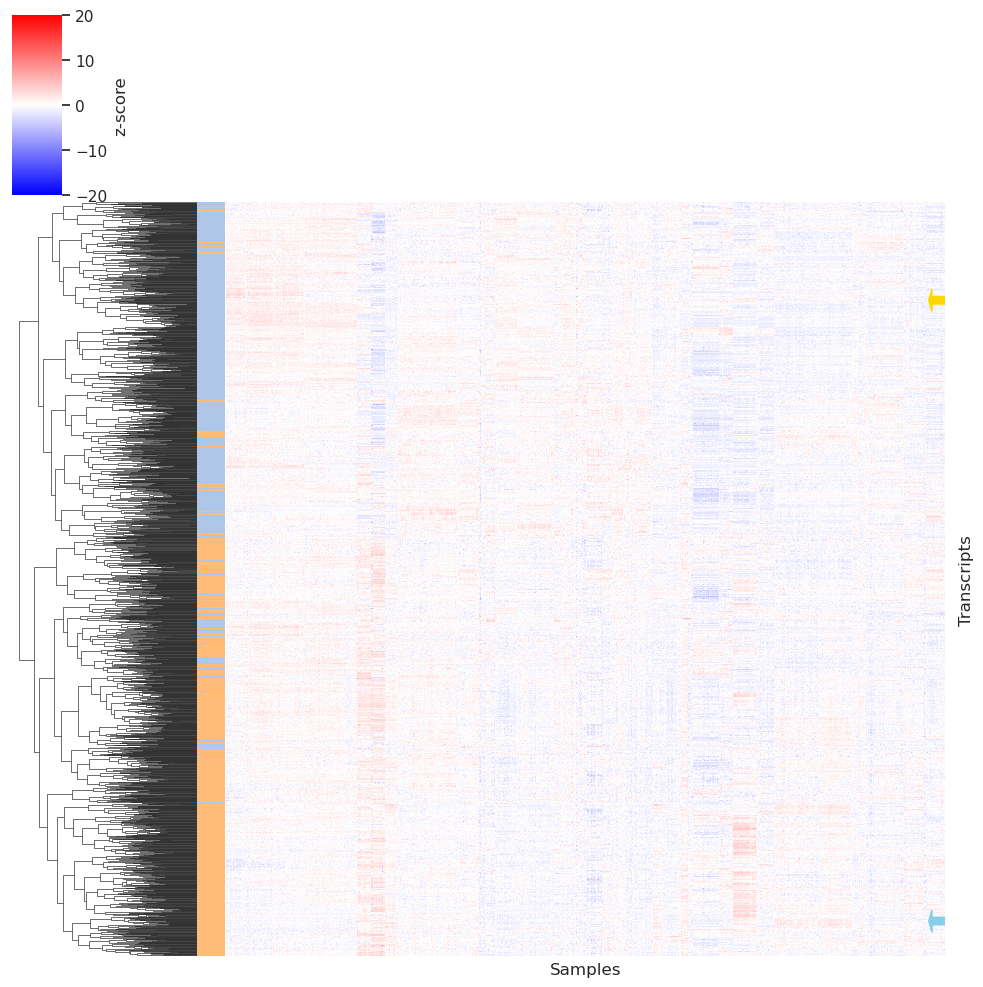

In [192]:
linkage_method = 'complete'
distance_metric = 'correlation'

twoc = test.iloc[cluster_indexes, clustergrid.dendrogram_col.reordered_ind]

clustergrid = seaborn.clustermap(
    twoc, 
    cmap='bwr', 
    row_cluster=True, 
    col_cluster=False, 
    vmin=-20, vmax=20, 
    cbar_kws={'label':'z-score'},
    xticklabels=False, yticklabels=False, 
    method=linkage_method, metric=distance_metric,
    row_colors=cmap(cluster_labels)
)

# adding where isoforms fall
loc1 = clustergrid.dendrogram_row.reordered_ind.index(twoc.index.get_loc(iso1))
loc2 = clustergrid.dendrogram_row.reordered_ind.index(twoc.index.get_loc(iso2))
ax = clustergrid.ax_heatmap
ax.add_patch(matplotlib.patches.Arrow(twoc.shape[1], loc1, dx=-100, dy=0, color='gold', width=100))
ax.add_patch(matplotlib.patches.Arrow(twoc.shape[1], loc2, dx=-100, dy=0, color='skyblue', width=100))
matplotlib.pyplot.show()

In [110]:
data = [
    [2.1, 2.1, 2, 2, 2],
    [4, 5, 6, 7, 8],
    [2, 2, 2, 2, 2],
    [4.1, 5.1, 6.1, 7.1, 8.1],
    [3, 3, 3, 3, 3],
    [3.1, 2.9, 2.9, 2.9, 2.9]
]

df = pandas.DataFrame(data, columns=['s0','s1', 's2', 's3', 's4'], index=['g0', 'g1', 'g2', 'g3', 'g4', 'g5'])
df

s0   s1   s2   s3   s4
g0  2.1  2.1  2.0  2.0  2.0
g1  4.0  5.0  6.0  7.0  8.0
g2  2.0  2.0  2.0  2.0  2.0
g3  4.1  5.1  6.1  7.1  8.1
g4  3.0  3.0  3.0  3.0  3.0
g5  3.1  2.9  2.9  2.9  2.9

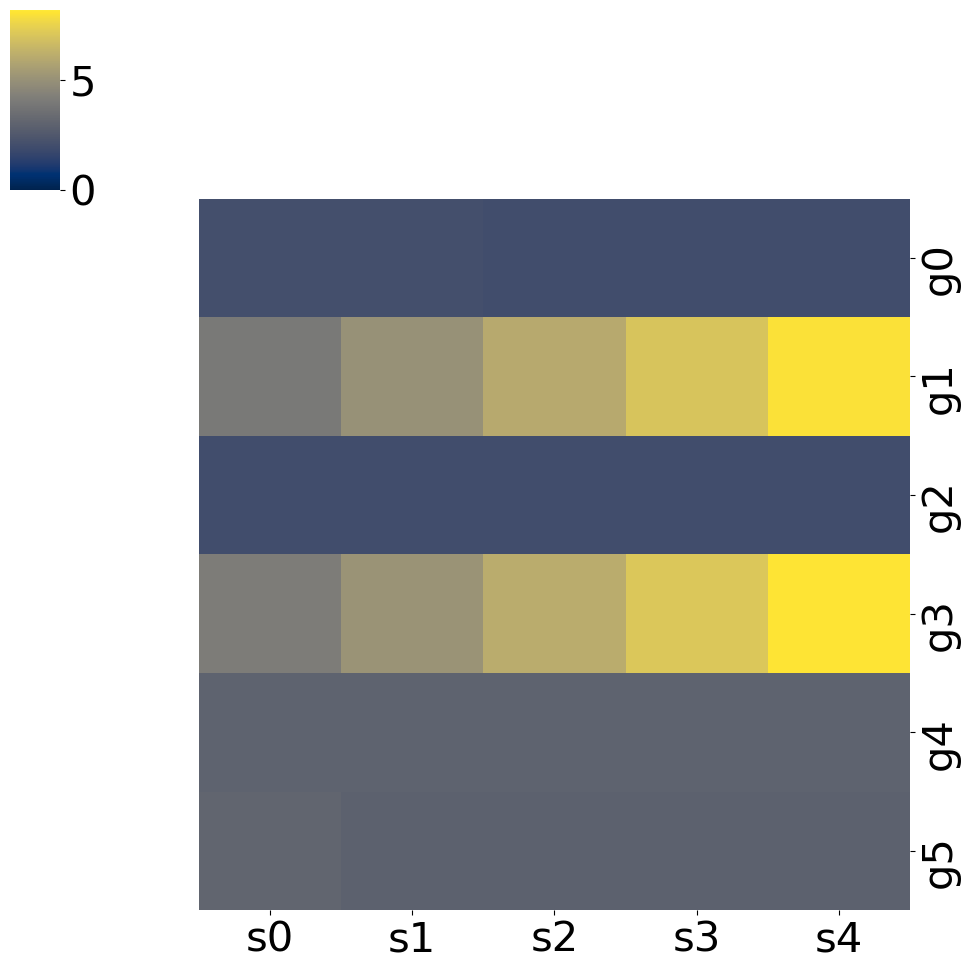

In [127]:
clustergrid = seaborn.clustermap(df,
                                 cmap='cividis', 
                                 vmin=0, vmax=8.2,
                                 row_cluster=False, 
                                 col_cluster=False, 
                                 xticklabels=True, yticklabels=True
                                )

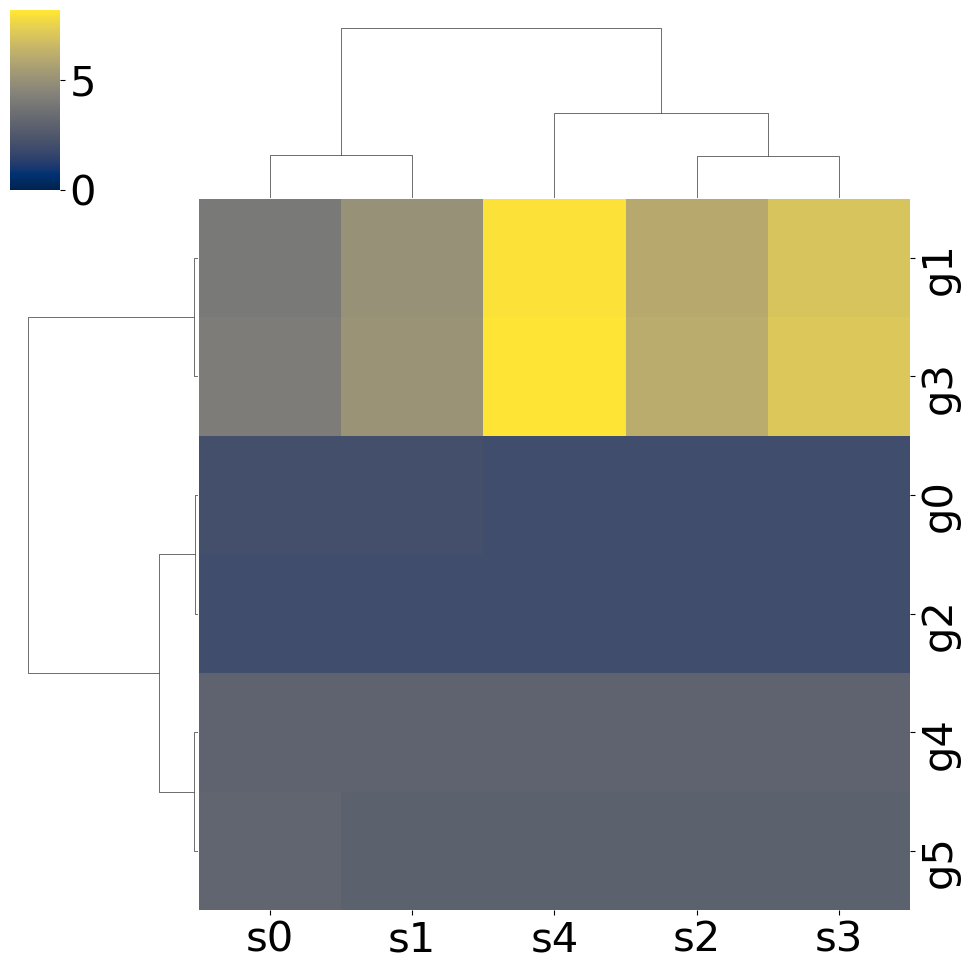

In [133]:
linkage_method = 'complete'
distance_metric = 'euclidean'

clustergrid = seaborn.clustermap(df, 
                                 cmap='cividis', 
                                 vmin=0, vmax=8.2,
                                 row_cluster=True, 
                                 col_cluster=True, 
                                 xticklabels=True, yticklabels=True,
                                 method=linkage_method, metric=distance_metric
                                )

In [134]:
clustergrid.dendrogram_row.reordered_ind

[1, 3, 0, 2, 4, 5]

In [135]:
clustergrid.dendrogram_col.reordered_ind

[0, 1, 4, 2, 3]

In [137]:
df.iloc[[4, 5], clustergrid.dendrogram_col.reordered_ind]

s0   s1   s4   s2   s3
g4  3.0  3.0  3.0  3.0  3.0
g5  3.1  2.9  2.9  2.9  2.9

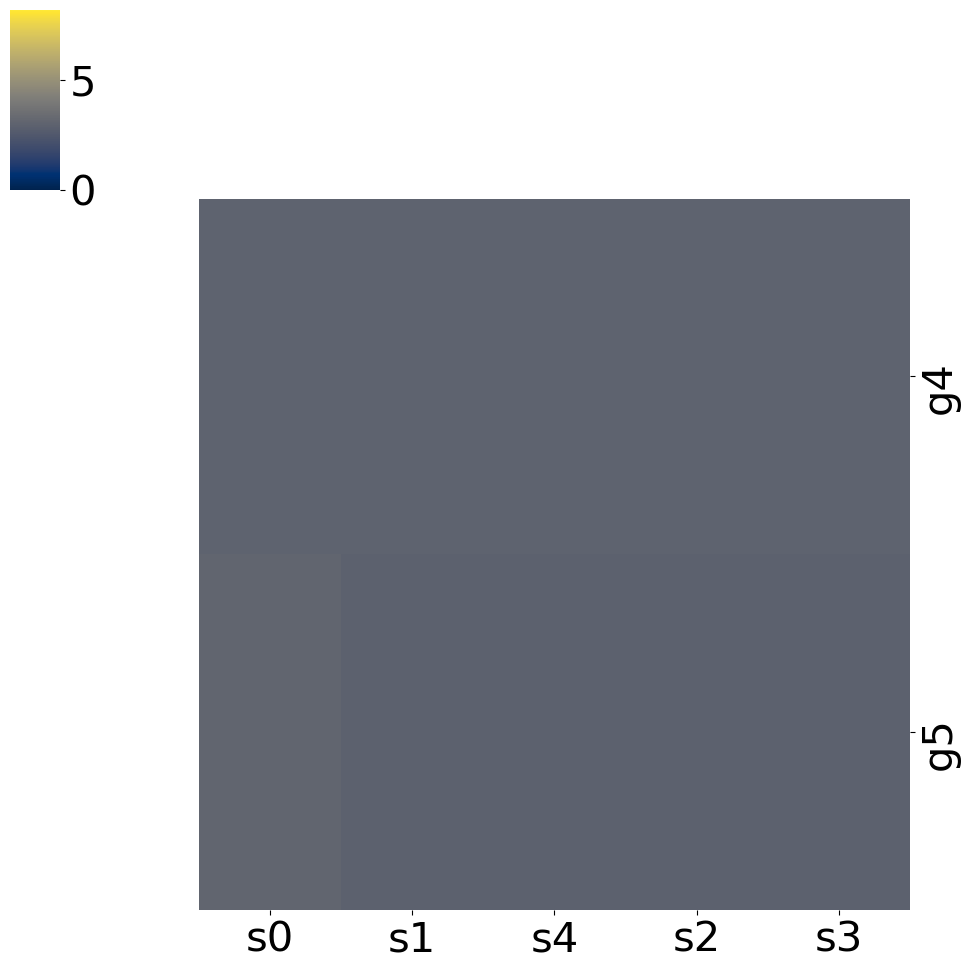

In [138]:
clustergrid = seaborn.clustermap(
    df.iloc[[4, 5], clustergrid.dendrogram_col.reordered_ind], 
    cmap='cividis', 
    vmin=0, vmax=8.2,
    row_cluster=False, 
    col_cluster=False, 
    xticklabels=True, yticklabels=True
)

In [ ]:
Run k-means and recover goodness and if isoforms are in different clusters. Then visualize in a heatmap.